# 0. Basic Setup and Exploration

In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.style.use('ggplot') # use ggplot style as in R
import seaborn as sns

from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
#from sklearn.neural_network import MLPRegressor
from math import sqrt

# make the output stable across runs
np.random.seed(42)

In [3]:
# read the data we concat 4 datasets from Lending Club for 2017
# ref: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

df1 = pd.read_csv('LoanStats_2017Q1.csv', encoding = 'latin-1', skiprows = 1, low_memory=False)
df2 = pd.read_csv('LoanStats_2017Q2.csv', encoding = 'latin-1', skiprows = 1, low_memory=False)
df3 = pd.read_csv('LoanStats_2017Q3.csv', encoding = 'latin-1', skiprows = 1, low_memory=False)
df4 = pd.read_csv('LoanStats_2017Q4.csv', encoding = 'latin-1', skiprows = 1, low_memory=False)

# combine 4 dataframes into 1 dataframe
frames = [df1, df2, df3, df4]
loan_raw = pd.concat(frames)

In [4]:
df1.shape,df2.shape,df3.shape,df4.shape

((96781, 145), (105453, 145), (122703, 145), (118650, 145))

In [5]:
loan_raw.shape

(443587, 145)

In [6]:
loan_raw.head()

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  NaN        NaN    16000.0      16000.0          16000.0   60 months   
1  NaN        NaN    11875.0      11875.0          11875.0   36 months   
2  NaN        NaN    12000.0      12000.0          12000.0   36 months   
3  NaN        NaN    25000.0      25000.0          25000.0   36 months   
4  NaN        NaN     1500.0       1500.0           1500.0   36 months   

  int_rate  installment grade sub_grade       ...         \
0   12.74%       361.93     C        C1       ...          
1   11.44%       391.26     B        B4       ...          
2    7.99%       375.99     A        A5       ...          
3   15.99%       878.81     C        C5       ...          
4    5.32%        45.18     A        A1       ...          

  hardship_payoff_balance_amount hardship_last_payment_amount  \
0                            NaN                          NaN   
1                            NaN                          NaN   
2                            NaN                          NaN   
3                            NaN                          NaN   
4                            NaN                          NaN   

  disbursement_method  debt_settlement_flag debt_settlement_flag_date  \
0                Cash                     N                       NaN   
1                Cash                     N                       NaN   
2                Cash                     N                       NaN   
3                Cash                     N                       NaN   
4                Cash                     N                       NaN   

  settlement_status settlement_date settlement_amount  settlement_percentage  \
0               NaN             NaN               NaN                    NaN   
1               NaN             NaN               NaN                    NaN   
2               NaN             NaN               NaN                    NaN   
3               NaN             NaN               NaN                    NaN   
4               NaN             NaN               NaN                    NaN   

   settlement_term  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  

[5 rows x 145 columns]

In [7]:
loan_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 443587 entries, 0 to 118649
Columns: 145 entries, id to settlement_term
dtypes: float64(107), object(38)
memory usage: 494.1+ MB


In [8]:
# describe the target column
print(loan_raw.loan_status.value_counts())

Current               278150
Fully Paid            116178
Charged Off            33595
Late (31-120 days)      9153
In Grace Period         4433
Late (16-30 days)       2058
Default                   12
Name: loan_status, dtype: int64


# 1. Data Cleaning

In [9]:
# we have noticed there are several useless columns, columns may have too many missing values
# thus we need to clean the dataset before we conduct any analysis and model training

## 1.0 Categorise the target variable 

In [10]:
# There are 7 loan statuses: 
#     - Charged Off,
#     - Current,
#     - Default,
#     - Fully Paid,
#     - In Grace Period,
#     - Late (16-30 days),
#     - Late (31-120 days).
# We consider Late (31-120 days), Default, Charged Off as a default loan and 
# Fully Paid as a desirable loan and ignore everything else. 
# We can create a shell script to filter such loan instead of loading the entire files.

In [11]:
# We create extract.sh to perform the task
# ref: https://rstudio-pubs-static.s3.amazonaws.com/203258_d20c1a34bc094151a0a1e4f4180c5f6f.html
# Then we execute the following command in the command line to filter only target statuses:
# sh extract.sh loan_2012_2013.csv loan_2012_2013.extract.csv
# sh extract.sh loan_2014.csv loan_2014.extract.csv
# sh extract.sh loan_2015.csv loan_2015.extract.csv

In [12]:
# extract dataframes which set 2 groups
dfe1 = pd.read_csv('LoanStats_2017Q1_extract.csv', encoding = 'latin-1', low_memory=False)
dfe2 = pd.read_csv('LoanStats_2017Q2_extract.csv', encoding = 'latin-1', low_memory=False)
dfe3 = pd.read_csv('LoanStats_2017Q3_extract.csv', encoding = 'latin-1', low_memory=False)
dfe4 = pd.read_csv('LoanStats_2017Q4_extract.csv', encoding = 'latin-1', low_memory=False)

frames = [dfe1, dfe2, dfe3, dfe4]

loan_extract = pd.concat(frames)

In [13]:
loan_extract.shape

(158938, 145)

In [14]:
loan_extract.head()

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0 NaN        NaN      16000        16000            16000   60 months   
1 NaN        NaN      12000        12000            12000   36 months   
2 NaN        NaN       6000         6000             6000   36 months   
3 NaN        NaN      35000        35000            35000   60 months   
4 NaN        NaN      14000        14000            14000   60 months   

  int_rate  installment grade sub_grade       ...         \
0   12.74%       361.93     C        C1       ...          
1    7.99%       375.99     A        A5       ...          
2   11.44%       197.69     B        B4       ...          
3   25.49%      1037.38     E        E4       ...          
4   15.99%       340.38     C        C5       ...          

  hardship_payoff_balance_amount hardship_last_payment_amount  \
0                            NaN                          NaN   
1                            NaN                          NaN   
2                            NaN                          NaN   
3                            NaN                          NaN   
4                            NaN                          NaN   

  disbursement_method  debt_settlement_flag debt_settlement_flag_date  \
0                Cash                     N                       NaN   
1                Cash                     N                       NaN   
2                Cash                     N                       NaN   
3                Cash                     N                       NaN   
4                Cash                     N                       NaN   

  settlement_status settlement_date settlement_amount  settlement_percentage  \
0               NaN             NaN               NaN                    NaN   
1               NaN             NaN               NaN                    NaN   
2               NaN             NaN               NaN                    NaN   
3               NaN             NaN               NaN                    NaN   
4               NaN             NaN               NaN                    NaN   

   settlement_term  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  

[5 rows x 145 columns]

In [15]:
print(loan_extract.loan_status.value_counts())

Fully Paid            116178
Charged Off            33595
Late (31-120 days)      9153
Default                   12
Name: loan_status, dtype: int64


## 1.1 Deal with missing values

In [16]:
# we can start with calculating the missing values for each column and get a basic idea
def count_null(column):
    return len(column[column.isnull()]) / len(column)

loan_extract.apply(count_null)[loan_extract.apply(count_null) > 0.5]

id                                            1.000000
member_id                                     1.000000
url                                           1.000000
desc                                          1.000000
mths_since_last_record                        0.803540
next_pymnt_d                                  0.942336
mths_since_last_major_derog                   0.720124
annual_inc_joint                              0.922391
dti_joint                                     0.922391
verification_status_joint                     0.922397
mths_since_recent_bc_dlq                      0.764329
mths_since_recent_revol_delinq                0.660081
revol_bal_joint                               0.931414
sec_app_earliest_cr_line                      0.931407
sec_app_inq_last_6mths                        0.931407
sec_app_mort_acc                              0.931407
sec_app_open_acc                              0.931407
sec_app_revol_util                            0.932496
sec_app_op

In [17]:
# now we can define a threshold to calculate the proportion of missing value
# then we can omitting the columns by setting the threshold
half_null = len(loan_extract) / 2 

loan2 = loan_extract.dropna(thresh = half_null, axis = 1)
loan2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158938 entries, 0 to 31397
Columns: 102 entries, loan_amnt to debt_settlement_flag
dtypes: float64(26), int64(52), object(24)
memory usage: 124.9+ MB


In [18]:
# note the columns were cut down to 102 from 145

In [19]:
# but in order to train a more which can be applied to different organisations (universal) 
# we have picked the following columns, but these could be changed afterwards if needed

columns = ['loan_amnt', 'term', 'int_rate', 'grade', 'dti', 'addr_state', 'home_ownership',
           'installment','acc_now_delinq', 'loan_status','purpose', 'annual_inc', 'emp_length', 'delinq_2yrs']
loan_select = loan_extract[columns]
loan_select.head()

loan_amnt        term int_rate grade    dti addr_state home_ownership  \
0      16000   60 months   12.74%     C   8.28         SD       MORTGAGE   
1      12000   36 months    7.99%     A  28.82         CA       MORTGAGE   
2       6000   36 months   11.44%     B  24.20         UT           RENT   
3      35000   60 months   25.49%     E  14.04         VA       MORTGAGE   
4      14000   60 months   15.99%     C  21.80         AL           RENT   

   installment  acc_now_delinq  loan_status             purpose  annual_inc  \
0       361.93               0   Fully Paid  debt_consolidation    130000.0   
1       375.99               0  Charged Off  debt_consolidation    100000.0   
2       197.69               0  Charged Off  debt_consolidation     25000.0   
3      1037.38               0   Fully Paid    home_improvement    114000.0   
4       340.38               0  Charged Off  debt_consolidation     43000.0   

  emp_length  delinq_2yrs  
0  10+ years            0  
1    9 years            0  
2    5 years            0  
3  10+ years            0  
4  10+ years            1

In [20]:
# let's check the data missing situation for selected columns
column_null = loan_select.apply(lambda x: x.isnull().value_counts())
column_null

loan_amnt      term  int_rate     grade     dti  addr_state  \
False   158938.0  158938.0  158938.0  158938.0  158777    158938.0   
True         NaN       NaN       NaN       NaN     161         NaN   

       home_ownership  installment  acc_now_delinq  loan_status   purpose  \
False        158938.0     158938.0        158938.0     158938.0  158938.0   
True              NaN          NaN             NaN          NaN       NaN   

       annual_inc  emp_length  delinq_2yrs  
False    158938.0      147381     158938.0  
True          NaN       11557          NaN

In [21]:
# drop the records with at least 1 missing values from the selected dataframe
loan = loan_select.dropna(how = 'any')
loan.apply(lambda x: x.isnull().value_counts())

loan_amnt    term  int_rate   grade     dti  addr_state  \
False     147371  147371    147371  147371  147371      147371   

       home_ownership  installment  acc_now_delinq  loan_status  purpose  \
False          147371       147371          147371       147371   147371   

       annual_inc  emp_length  delinq_2yrs  
False      147371      147371       147371

In [22]:
loan.shape
# now we have the cleaned dataframe with no missing value

(147371, 14)

In [23]:
loan.head()

loan_amnt        term int_rate grade    dti addr_state home_ownership  \
0      16000   60 months   12.74%     C   8.28         SD       MORTGAGE   
1      12000   36 months    7.99%     A  28.82         CA       MORTGAGE   
2       6000   36 months   11.44%     B  24.20         UT           RENT   
3      35000   60 months   25.49%     E  14.04         VA       MORTGAGE   
4      14000   60 months   15.99%     C  21.80         AL           RENT   

   installment  acc_now_delinq  loan_status             purpose  annual_inc  \
0       361.93               0   Fully Paid  debt_consolidation    130000.0   
1       375.99               0  Charged Off  debt_consolidation    100000.0   
2       197.69               0  Charged Off  debt_consolidation     25000.0   
3      1037.38               0   Fully Paid    home_improvement    114000.0   
4       340.38               0  Charged Off  debt_consolidation     43000.0   

  emp_length  delinq_2yrs  
0  10+ years            0  
1    9 years            0  
2    5 years            0  
3  10+ years            0  
4  10+ years            1

In [24]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147371 entries, 0 to 31397
Data columns (total 14 columns):
loan_amnt         147371 non-null int64
term              147371 non-null object
int_rate          147371 non-null object
grade             147371 non-null object
dti               147371 non-null float64
addr_state        147371 non-null object
home_ownership    147371 non-null object
installment       147371 non-null float64
acc_now_delinq    147371 non-null int64
loan_status       147371 non-null object
purpose           147371 non-null object
annual_inc        147371 non-null float64
emp_length        147371 non-null object
delinq_2yrs       147371 non-null int64
dtypes: float64(3), int64(3), object(8)
memory usage: 16.9+ MB


## 1.2 Value Standardisation

In [25]:
# first we need to remove all space within the records which is before and after the string values
def str_trip(col):
    if col.dtype == 'O':
        return col.map(str.strip)
    else:
        return col

loan.apply(str_trip).head()

loan_amnt       term int_rate grade    dti addr_state home_ownership  \
0      16000  60 months   12.74%     C   8.28         SD       MORTGAGE   
1      12000  36 months    7.99%     A  28.82         CA       MORTGAGE   
2       6000  36 months   11.44%     B  24.20         UT           RENT   
3      35000  60 months   25.49%     E  14.04         VA       MORTGAGE   
4      14000  60 months   15.99%     C  21.80         AL           RENT   

   installment  acc_now_delinq  loan_status             purpose  annual_inc  \
0       361.93               0   Fully Paid  debt_consolidation    130000.0   
1       375.99               0  Charged Off  debt_consolidation    100000.0   
2       197.69               0  Charged Off  debt_consolidation     25000.0   
3      1037.38               0   Fully Paid    home_improvement    114000.0   
4       340.38               0  Charged Off  debt_consolidation     43000.0   

  emp_length  delinq_2yrs  
0  10+ years            0  
1    9 years            0  
2    5 years            0  
3  10+ years            0  
4  10+ years            1

In [26]:
# then we capitalize the letters in address status
loan.addr_state = loan.addr_state.map(str.upper)

/Users/simon/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [27]:
# check if duplicate values exist
loan.duplicated().value_counts()

False    147371
dtype: int64

In [28]:
# remove the duplicate values
loan = loan.drop_duplicates(keep = 'first')
loan.duplicated().value_counts()

False    147371
dtype: int64

In [29]:
loan.shape
# now we have the cleaned dataset for training the algorithm

(147371, 14)

## 1.3 Label Encoding

In [30]:
# before fit our data into machine learning classifiers, we need to create dummy variables for the object values

# A helper function that converts 
# ["a", "b", "a", "c"] into
# [1, 2, 1, 3]
# This allows the machine learning algorithims to work on integers instead of strings
def categorize(l):
    uniques = sorted(list(set(l)))
    return [uniques.index(x) + 1 for x in l]

In [31]:
# for our target, we want to manually assign the category number for the visualization
# first, we get an idea about the number of different values of the loan_status column
print(loan.loan_status.value_counts())

Fully Paid            108771
Charged Off            30247
Late (31-120 days)      8342
Default                   11
Name: loan_status, dtype: int64


In [32]:
# now we categorize the Charged Off, Default, and Late (31-120 days) to a single category: Default with index 0
# and the Fully Paid with index 1
    
loan_df = pd.DataFrame()
loan_df['loan_amnt'] = loan['loan_amnt']
loan_df['term'] = categorize(loan['term'])
loan_df['int_rate'] = loan['int_rate'].str[:-1].astype(float)
loan_df['grade'] = categorize(loan['grade'])
loan_df['addr_state'] = categorize(loan['addr_state'])
loan_df['purpose'] = categorize(loan['purpose'])
loan_df['annual_inc'] = loan['annual_inc']
loan_df['emp_length'] = categorize(loan['emp_length'])
loan_df['delinq_2yrs'] = loan['delinq_2yrs']
loan_df['dti'] = loan['dti']
loan_df['home_ownership'] = categorize(loan['home_ownership'])
loan_df['installment'] = loan['installment']
loan_df['acc_now_delinq'] = loan['acc_now_delinq']
# loan_df['loan_status'] = categorize(loan['loan_status'])
# manually
loan_status = {
#                 'Current':0,
                'Fully Paid':1, 
#                 'In Grace Period':2, 
#                 'Late (16-30 days)':3, 
                'Late (31-120 days)':0, 
                'Charged Off':0,
                'Default':0
}
loan_df['loan_status'] = loan['loan_status'].map(loan_status)


In [33]:
loan_df.head()

loan_amnt  term  int_rate  grade  addr_state  purpose  annual_inc  \
0      16000     2     12.74      3          41        3    130000.0   
1      12000     1      7.99      1           5        3    100000.0   
2       6000     1     11.44      2          44        3     25000.0   
3      35000     2     25.49      5          45        4    114000.0   
4      14000     2     15.99      3           2        3     43000.0   

   emp_length  delinq_2yrs    dti  home_ownership  installment  \
0           2            0   8.28               2       361.93   
1          10            0  28.82               2       375.99   
2           6            0  24.20               5       197.69   
3           2            0  14.04               2      1037.38   
4           2            1  21.80               5       340.38   

   acc_now_delinq  loan_status  
0               0            1  
1               0            0  
2               0            0  
3               0            1  
4               0            0

In [34]:
# recall the loan
loan.head()

loan_amnt        term int_rate grade    dti addr_state home_ownership  \
0      16000   60 months   12.74%     C   8.28         SD       MORTGAGE   
1      12000   36 months    7.99%     A  28.82         CA       MORTGAGE   
2       6000   36 months   11.44%     B  24.20         UT           RENT   
3      35000   60 months   25.49%     E  14.04         VA       MORTGAGE   
4      14000   60 months   15.99%     C  21.80         AL           RENT   

   installment  acc_now_delinq  loan_status             purpose  annual_inc  \
0       361.93               0   Fully Paid  debt_consolidation    130000.0   
1       375.99               0  Charged Off  debt_consolidation    100000.0   
2       197.69               0  Charged Off  debt_consolidation     25000.0   
3      1037.38               0   Fully Paid    home_improvement    114000.0   
4       340.38               0  Charged Off  debt_consolidation     43000.0   

  emp_length  delinq_2yrs  
0  10+ years            0  
1    9 years            0  
2    5 years            0  
3  10+ years            0  
4  10+ years            1

In [35]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147371 entries, 0 to 31397
Data columns (total 14 columns):
loan_amnt         147371 non-null int64
term              147371 non-null int64
int_rate          147371 non-null float64
grade             147371 non-null int64
addr_state        147371 non-null int64
purpose           147371 non-null int64
annual_inc        147371 non-null float64
emp_length        147371 non-null int64
delinq_2yrs       147371 non-null int64
dti               147371 non-null float64
home_ownership    147371 non-null int64
installment       147371 non-null float64
acc_now_delinq    147371 non-null int64
loan_status       147371 non-null int64
dtypes: float64(4), int64(10)
memory usage: 16.9 MB


In [36]:
# check the target columns distribution
# Fully Paid == 1
#    Default == 0
print(loan_df.loan_status.value_counts())

1    108771
0     38600
Name: loan_status, dtype: int64


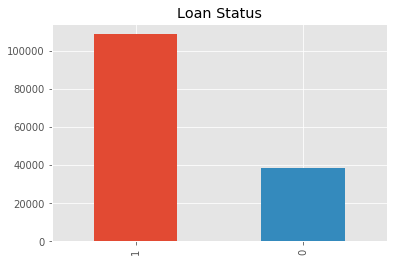

In [37]:
loan_df.loan_status.value_counts().plot(kind='bar', title='Loan Status');

## 1.4 Treatment for Imbalance: Resampling

In [38]:
# ref: https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

# Class count
count_class_1, count_class_0 = loan_df.loan_status.value_counts()

# Divide by class
df_class_0 = loan_df[loan_df['loan_status'] == 0]
df_class_1 = loan_df[loan_df['loan_status'] == 1]

print(count_class_0,count_class_1)

38600 108771


Random under-sampling:
1    38600
0    38600
Name: loan_status, dtype: int64


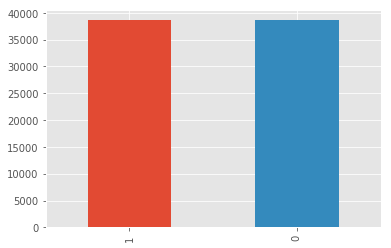

In [39]:
# undersampling the class 1
df_class_1_under = df_class_1.sample(count_class_0)
loan_under = pd.concat([df_class_1_under, df_class_0], axis=0)

print('Random under-sampling:')
print(loan_under.loan_status.value_counts())

loan_under.loan_status.value_counts().plot(kind='bar');

# 2. Machine Learning 

## 2.0 Target Variable Exploring

In [40]:
# now we need to have an idea about our target variable: loan_status
print("Total records:", loan_under.shape[0])
print(loan_under.loan_status.value_counts())

# the "current" and "fully paid" records are perceived as in good status
# print((151931+227)/180294)

Total records: 77200
1    38600
0    38600
Name: loan_status, dtype: int64


## 2.1 Decision Tree Classifier

In [41]:
# Selecting the input and output features for tasks

features = ['loan_amnt', 'term', 'int_rate', 'grade', 'addr_state','purpose', 'annual_inc', 
            'emp_length', 'delinq_2yrs','dti','home_ownership','installment','acc_now_delinq']

target = ['loan_status']

X = loan_under[features]
y = loan_under[target]

# Visualize the combined table 
# (which should looks the same as the original dataset only we put the "loan_status" to the last)
pd.concat([X, y], axis=1, sort=False).head()

loan_amnt  term  int_rate  grade  addr_state  purpose  annual_inc  \
39560      23000     1     13.99      3          48        3    187000.0   
10857      18000     2     10.42      2          35        3     57000.0   
20414      15000     2     20.00      4          14        3    168000.0   
22461      20400     2     12.74      3          19        2     43500.0   
4151        6400     1     13.49      3          34        2     77000.0   

       emp_length  delinq_2yrs    dti  home_ownership  installment  \
39560           4            1  14.87               2       785.98   
10857           6            0  14.08               2       386.18   
20414           4            0  19.58               5       397.41   
22461           2            5  20.17               2       461.46   
4151            2            1  21.66               2       217.16   

       acc_now_delinq  loan_status  
39560               0            1  
10857               0            1  
20414               0            1  
22461               0            1  
4151                0            1

In [42]:
# Split dataset into training set & test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=200)

In [43]:
# Fit on train set
# loan_clf = DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10, random_state=200)
loan_clf = DecisionTreeClassifier(random_state = 42, max_depth = 9, max_features = 9, max_leaf_nodes=200)
loan_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=9, max_leaf_nodes=200, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

In [44]:
# Predict on test data
prediction = loan_clf.predict(X_test)
print(prediction[:5])
print('-'*10)
print(y_test['loan_status'][:5])

[1 0 0 1 0]
----------
28396    1
27556    0
3490     0
7182     0
6914     1
Name: loan_status, dtype: int64


Decision Tree Accuracy: 0.6319300518134715 

Confusion matrix:
 [[5153 2603]
 [3080 4604]]


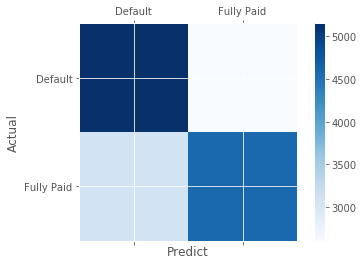

In [48]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

print("Decision Tree Accuracy:",metrics.accuracy_score(y_test, loan_clf.predict(X_test)),"\n")

conf_mat = confusion_matrix(y_test, loan_clf.predict(X_test))
print('Confusion matrix:\n', conf_mat)

labels = ['Default', 'Fully Paid']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()


In [49]:
from sklearn.model_selection import cross_val_predict, cross_val_score
cv = 3
print('AUC: %.5f +/- %.4f' % (np.mean(cross_val_score(loan_clf,X_train,y_train,cv=cv,scoring='roc_auc')),np.std(cross_val_score(loan_clf,X_train,y_train,cv=cv,scoring='roc_auc'))))

AUC: 0.67720 +/- 0.0024


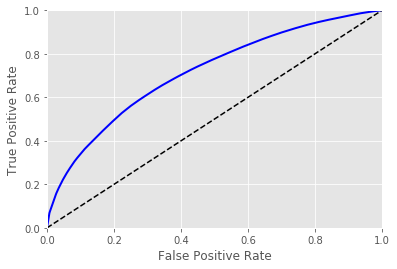

ROC/AUC score for training set is 0.714


In [50]:
# Plot the ROC curve
from sklearn.metrics import roc_curve, roc_auc_score
probs = loan_clf.predict_proba(X_train)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_train, preds)
roc_auc = roc_auc_score(y_train, preds)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, 'b', linewidth=2, label = 'AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()
        
print('ROC/AUC score for training set is %0.3f' % roc_auc_score(y_train, preds))

## 2.1.1 Grid Search

In [265]:
classifier = DecisionTreeClassifier(random_state = 42)
parameters = {
              'max_depth': range(3,10),
              'max_features': range(3,10),
              'max_leaf_nodes':[5,10,20,100,200],
             }
scoring_fnc = make_scorer(accuracy_score)
kfold = KFold(n_splits=10)

grid = GridSearchCV(classifier, parameters, scoring_fnc, cv=kfold)
grid = grid.fit(X_train, y_train)

clf = grid.best_estimator_

print('best score: %f'%grid.best_score_)
print('best parameters:')
for key in parameters.keys():
    print('%s: %d'%(key, clf.get_params()[key]))

print('test score: %f'%clf.score(X_test, y_test))

pd.DataFrame(grid.cv_results_).T

best score: 0.635832
best parameters:
max_depth: 7
max_features: 8
max_leaf_nodes: 100
test score: 0.634585


/Users/simon/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/simon/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/simon/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/simon/anaconda3/lib/pyth

0    \
mean_fit_time                                                 0.0278311   
std_fit_time                                                 0.00654339   
mean_score_time                                              0.00173337   
std_score_time                                              0.000584866   
param_max_depth                                                       3   
param_max_features                                                    3   
param_max_leaf_nodes                                               None   
params                {'max_depth': 3, 'max_features': 3, 'max_leaf_...   
split0_test_score                                              0.621924   
split1_test_score                                              0.628886   
split2_test_score                                              0.630991   
split3_test_score                                              0.622733   
split4_test_score                                              0.623705   
split5_test_score                                              0.625162   
split6_test_score                                              0.619495   
split7_test_score                                              0.627753   
split8_test_score                                              0.627105   
split9_test_score                                              0.634391   
mean_test_score                                                0.626214   
std_test_score                                               0.00427857   
rank_test_score                                                     163   
split0_train_score                                             0.629876   
split1_train_score                                              0.62885   
split2_train_score                                             0.629012   
split3_train_score                                             0.630379   
split4_train_score                                             0.629804   
split5_train_score                                             0.627843   
split6_train_score                                             0.630289   
split7_train_score                                             0.629642   
split8_train_score                                             0.629858   
split9_train_score                                             0.628886   
mean_train_score                                               0.629444   
std_train_score                                             0.000743653   

                                                                    1    \
mean_fit_time                                                 0.0283394   
std_fit_time                                                0.000574712   
mean_score_time                                              0.00165679   
std_score_time                                              0.000246229   
param_max_depth                                                       3   
param_max_features                                                    3   
param_max_leaf_nodes                                                  5   
params                {'max_depth': 3, 'max_features': 3, 'max_leaf_...   
split0_test_score                                              0.626943   
split1_test_score                                              0.630343   
split2_test_score                                              0.631153   
split3_test_score                                              0.618199   
split4_test_score                                              0.617876   
split5_test_score                                              0.625162   
split6_test_score                                              0.617066   
split7_test_score                                              0.631315   
split8_test_score                                              0.625162   
split9_test_score                                              0.629372   
mean_test_score                                                0.625259   
std_test_score   

## 2.2 Random Forest

/Users/simon/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/simon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Random Forest Accuracy: 0.6094559585492227 

Confusion matrix:
 [[5403 2353]
 [3677 4007]]


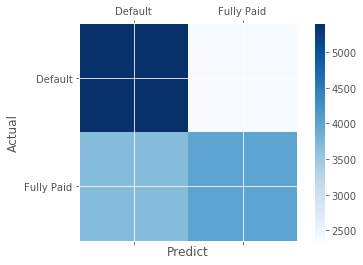

In [52]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

print("Random Forest Accuracy:", metrics.accuracy_score(y_test, rf_clf.predict(X_test)),"\n")
conf_mat = confusion_matrix(y_test, rf_clf.predict(X_test))
print('Confusion matrix:\n', conf_mat)

labels = ['Default', 'Fully Paid']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [53]:
from sklearn.model_selection import cross_val_predict, cross_val_score
cv = 3
print('AUC: %.5f +/- %.4f' % (np.mean(cross_val_score(rf_clf,X_train,y_train,cv=cv,scoring='roc_auc')),np.std(cross_val_score(rf_clf,X_train,y_train,cv=cv,scoring='roc_auc'))))

/Users/simon/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/simon/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/simon/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/simon/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConvers

AUC: 0.64600 +/- 0.0014


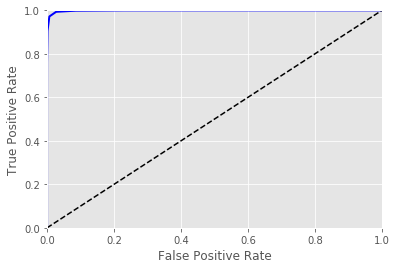

ROC/AUC score for training set is 0.999


In [55]:
# Plot the ROC curve
from sklearn.metrics import roc_curve, roc_auc_score
probs = rf_clf.predict_proba(X_train)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_train, preds)
roc_auc = roc_auc_score(y_train, preds)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, 'b', linewidth=2, label = 'AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()
        
print('ROC/AUC score for training set is %0.3f' % roc_auc_score(y_train, preds))

# 3. Decision Tree Visualization

In [56]:
feature_names = np.array(features)
target_names = ['Default',
                'Fully Paid']

### Below are two ways of code to visualize the tree

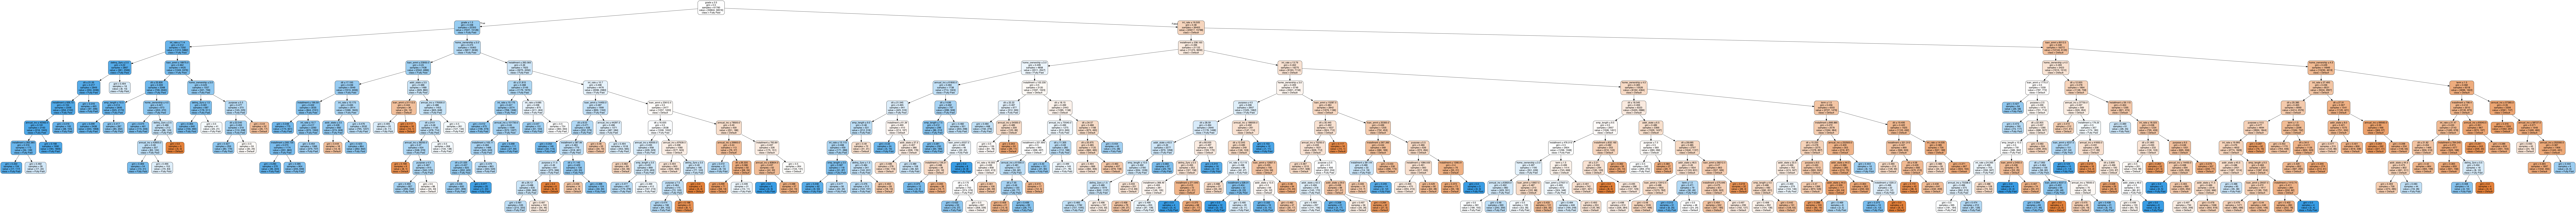

In [57]:
from IPython.display import Image  
import pydotplus
from sklearn.externals.six import StringIO
from sklearn import tree

dot_data = tree.export_graphviz(loan_clf, out_file=None,
                         feature_names=feature_names,
                         class_names=target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
graph.write_png("loan.png")
Image(graph.create_png()) 

In [58]:
from sklearn.externals.six import StringIO
from sklearn import tree
import pydotplus # install: conda install -c conda-forge pydotplus
# import pydot # install: conda install -c conda-forge pydot
# import graphviz # install: conda install python-graphviz
from PIL import Image

dot_data = tree.export_graphviz(loan_clf, out_file=None, 
                     feature_names=feature_names,  
                     class_names=target_names, 
                     filled=True, rounded=True,  
                     special_characters=True)  
# below is one way to visualize the tree, but the problem is the picture is too large
graph = graphviz.Source(dot_data) 
graph

NameError: name 'graphviz' is not defined